In [1]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

df = pd.read_csv("311_data.csv", parse_dates=["Created Date", "Closed Date"])

df["Resolution_Hours"] = (df["Closed Date"] - df["Created Date"]).dt.total_seconds() / 3600

duckdb.register("complaints", df)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

summary = df.groupby("Complaint Type").agg(
    Total_Cases=("Unique Key", "count"),
    Resolved_Cases=("Is_Resolved", "sum"),
    Avg_Resolution_Hours=("Resolution_Hours", "mean")
).reset_index()

summary["Resolved_Rate (%)"] = (summary["Resolved_Cases"] / summary["Total_Cases"] * 100).round(2)
summary["Avg_Resolution_Hours"] = summary["Avg_Resolution_Hours"].round(2)


In [13]:
volume_median = summary["Total_Cases"].median()
print("Median complaint volume:", volume_median)

summary_filtered = summary[summary["Total_Cases"] > volume_median].copy()


Median complaint volume: 643.0


In [14]:
x_median = summary_filtered["Avg_Resolution_Hours"].median()
y_median = summary_filtered["Resolved_Rate (%)"].median()
print("Avg Resolution Time (Median):", x_median)
print("Resolution Rate (Median):", y_median)


Avg Resolution Time (Median): 140.32
Resolution Rate (Median): 94.21


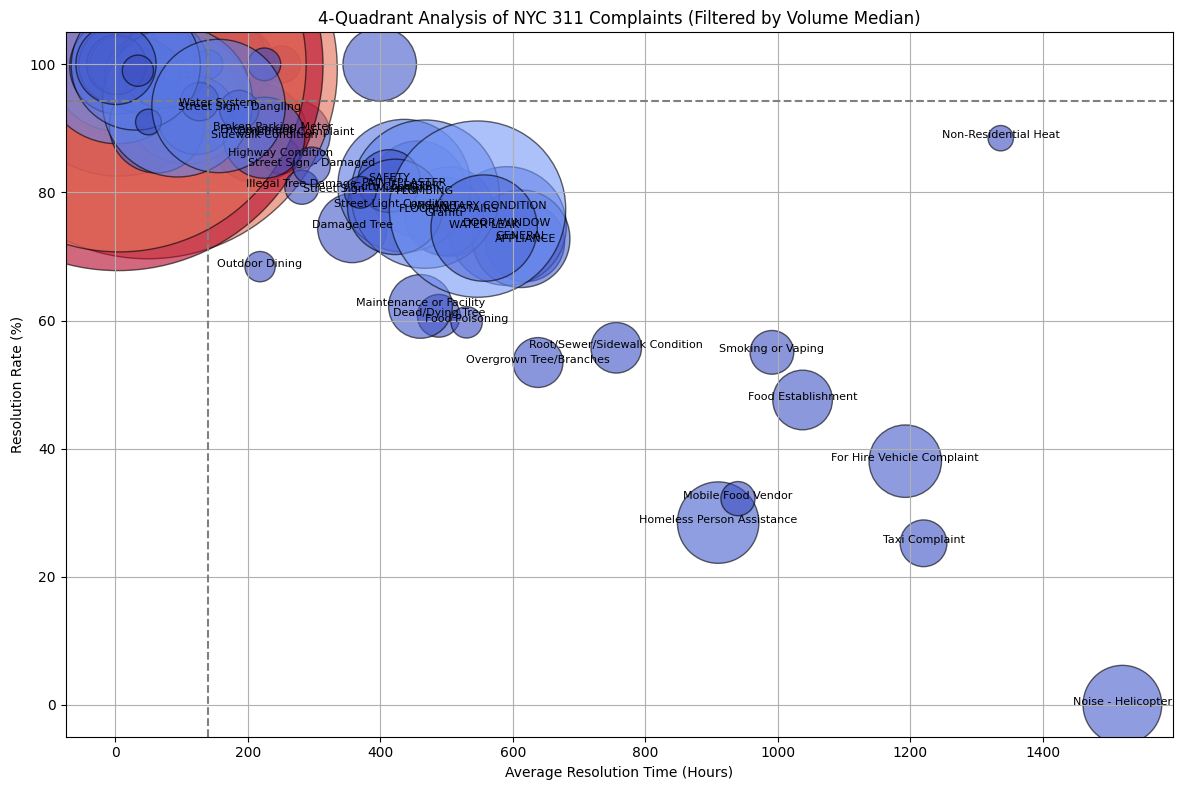

In [15]:
plt.figure(figsize=(12, 8))
plt.scatter(
    summary_filtered["Avg_Resolution_Hours"],
    summary_filtered["Resolved_Rate (%)"],
    s=summary_filtered["Total_Cases"] / 2,  # Bubble size
    alpha=0.6,
    c=summary_filtered["Total_Cases"],
    cmap="coolwarm",
    edgecolors="black"
)

# Add quadrant lines
plt.axvline(x=x_median, color="gray", linestyle="--")
plt.axhline(y=y_median, color="gray", linestyle="--")

# Label only the quadrant of concern: high time, low resolve rate
for i, row in summary_filtered.iterrows():
    if (row["Avg_Resolution_Hours"] > x_median) and (row["Resolved_Rate (%)"] < y_median):
        plt.text(row["Avg_Resolution_Hours"], row["Resolved_Rate (%)"], row["Complaint Type"], fontsize=8, ha='center')

plt.xlabel("Average Resolution Time (Hours)")
plt.ylabel("Resolution Rate (%)")
plt.title("4-Quadrant Analysis of NYC 311 Complaints (Filtered by Volume Median)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
problem_quadrant = summary_filtered[
    (summary_filtered["Avg_Resolution_Hours"] > x_median) &
    (summary_filtered["Resolved_Rate (%)"] < y_median)
]

print("🚨 Key underperforming complaint types:")
problem_quadrant = problem_quadrant.sort_values("Total_Cases", ascending=False)
problem_quadrant.head(10)


🚨 Key underperforming complaint types:


,Complaint Type,Total_Cases,Resolved_Cases,Avg_Resolution_Hours,Resolved_Rate (%)
160,UNSANITARY CONDITION,32241,24955,546.57,77.40
119,PLUMBING,22816,18193,467.54,79.74
173,Water System,18437,17239,155.60,93.50
118,PAINT/PLASTER,18275,14811,435.87,81.05
35,DOOR/WINDOW,14623,10932,591.06,74.76
170,WATER LEAK,11731,8733,556.53,74.44
54,Encampment,10236,9143,213.62,89.32
63,GENERAL,9868,7181,612.45,72.77
49,ELECTRIC,9490,7647,456.88,80.58
147,Street Light Condition,9441,7340,422.32,77.75


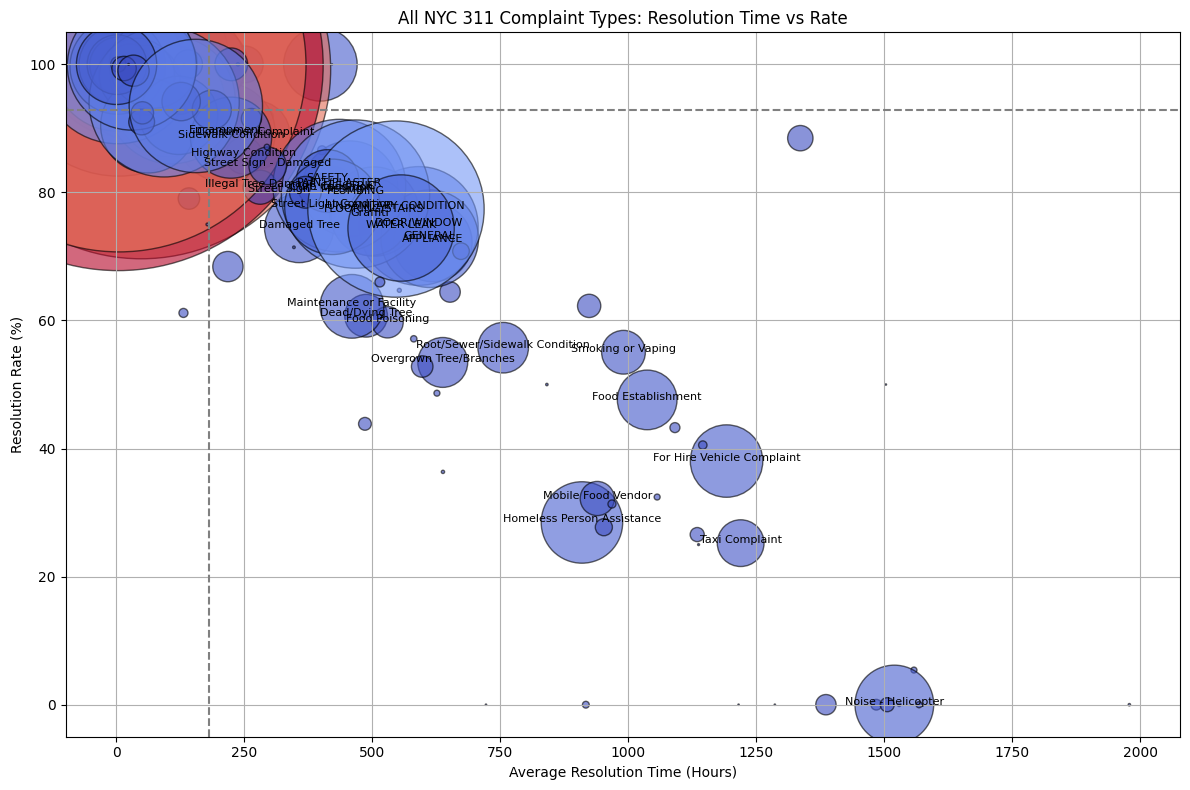

In [17]:
import matplotlib.pyplot as plt

# Use your full 'summary' DataFrame (not filtered)
x_median = summary["Avg_Resolution_Hours"].median()
y_median = summary["Resolved_Rate (%)"].median()

plt.figure(figsize=(12, 8))
plt.scatter(
    summary["Avg_Resolution_Hours"],
    summary["Resolved_Rate (%)"],
    s=summary["Total_Cases"] / 2,  # scale bubble size
    alpha=0.6,
    c=summary["Total_Cases"],  # color = volume
    cmap="coolwarm",
    edgecolors="black"
)

# Add quadrant lines
plt.axvline(x=x_median, color="gray", linestyle="--")
plt.axhline(y=y_median, color="gray", linestyle="--")

# Optional: label only large or interesting complaints to avoid clutter
for i, row in summary.iterrows():
    if row["Total_Cases"] > 1000 and row["Resolved_Rate (%)"] < y_median and row["Avg_Resolution_Hours"] > x_median:
        plt.text(row["Avg_Resolution_Hours"], row["Resolved_Rate (%)"], row["Complaint Type"], fontsize=8, ha='center')

plt.xlabel("Average Resolution Time (Hours)")
plt.ylabel("Resolution Rate (%)")
plt.title("All NYC 311 Complaint Types: Resolution Time vs Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Sort from lower right to upper left
worst_to_best = summary.sort_values(
    by=["Avg_Resolution_Hours", "Resolved_Rate (%)"],
    ascending=[False, True]
)

# Show top 15 problem types
worst_to_best[["Complaint Type", "Total_Cases", "Avg_Resolution_Hours", "Resolved_Rate (%)"]].head(15)


,Complaint Type,Total_Cases,Avg_Resolution_Hours,Resolved_Rate (%)
135,SNW,6,1979.03,0.00
157,Tobacco or Non-Tobacco Sale,39,1568.32,0.00
62,Found Property,37,1558.31,5.41
67,Green Taxi Report,14,1529.43,0.00
105,Noise - Helicopter,6427,1519.99,0.03
156,Taxi Report,204,1506.09,0.00
155,Taxi Licensee Complaint,2,1503.42,50.00
61,For Hire Vehicle Report,119,1484.74,0.00
27,Construction Lead Dust,430,1386.37,0.00
112,Non-Residential Heat,668,1336.35,88.47


In [27]:
x_median = summary_filtered["Avg_Resolution_Hours"].median()
y_median = summary_filtered["Resolved_Rate (%)"].median()


In [28]:
# Sort by: longest time first, lowest resolution rate first
ranked_filtered = summary_filtered.sort_values(
    by=["Avg_Resolution_Hours", "Resolved_Rate (%)"],
    ascending=[False, True]
)

# Show top 15 (bottom-right quadrant first)
ranked_filtered[["Complaint Type", "Total_Cases", "Avg_Resolution_Hours", "Resolved_Rate (%)"]].head(15)


,Complaint Type,Total_Cases,Avg_Resolution_Hours,Resolved_Rate (%)
105,Noise - Helicopter,6427,1519.99,0.03
112,Non-Residential Heat,668,1336.35,88.47
153,Taxi Complaint,2267,1219.83,25.23
60,For Hire Vehicle Complaint,5445,1192.24,38.05
58,Food Establishment,3689,1037.24,47.60
141,Smoking or Vaping,1984,990.94,55.04
98,Mobile Food Vendor,1211,939.70,32.20
75,Homeless Person Assistance,6883,909.78,28.46
133,Root/Sewer/Sidewalk Condition,2651,755.93,55.75
117,Overgrown Tree/Branches,2582,637.87,53.45


In [29]:
def classify_quadrant(row):
    if row["Avg_Resolution_Hours"] > x_median and row["Resolved_Rate (%)"] < y_median:
        return "Slow & Unresolved"
    elif row["Avg_Resolution_Hours"] <= x_median and row["Resolved_Rate (%)"] < y_median:
        return "Fast but Unresolved"
    elif row["Avg_Resolution_Hours"] > x_median and row["Resolved_Rate (%)"] >= y_median:
        return "Slow but Resolved"
    else:
        return "Fast & Resolved"

summary_filtered["Quadrant"] = summary_filtered.apply(classify_quadrant, axis=1)


In [30]:
summary_filtered[summary_filtered["Quadrant"] == "Slow & Unresolved"].sort_values(
    by=["Avg_Resolution_Hours", "Resolved_Rate (%)"],
    ascending=[False, True]
).head(10)


,Complaint Type,Total_Cases,Resolved_Cases,Avg_Resolution_Hours,Resolved_Rate (%),Quadrant
105,Noise - Helicopter,6427,2,1519.99,0.03,Slow & Unresolved
112,Non-Residential Heat,668,591,1336.35,88.47,Slow & Unresolved
153,Taxi Complaint,2267,572,1219.83,25.23,Slow & Unresolved
60,For Hire Vehicle Complaint,5445,2072,1192.24,38.05,Slow & Unresolved
58,Food Establishment,3689,1756,1037.24,47.60,Slow & Unresolved
141,Smoking or Vaping,1984,1092,990.94,55.04,Slow & Unresolved
98,Mobile Food Vendor,1211,390,939.70,32.20,Slow & Unresolved
75,Homeless Person Assistance,6883,1959,909.78,28.46,Slow & Unresolved
133,Root/Sewer/Sidewalk Condition,2651,1478,755.93,55.75,Slow & Unresolved
117,Overgrown Tree/Branches,2582,1380,637.87,53.45,Slow & Unresolved


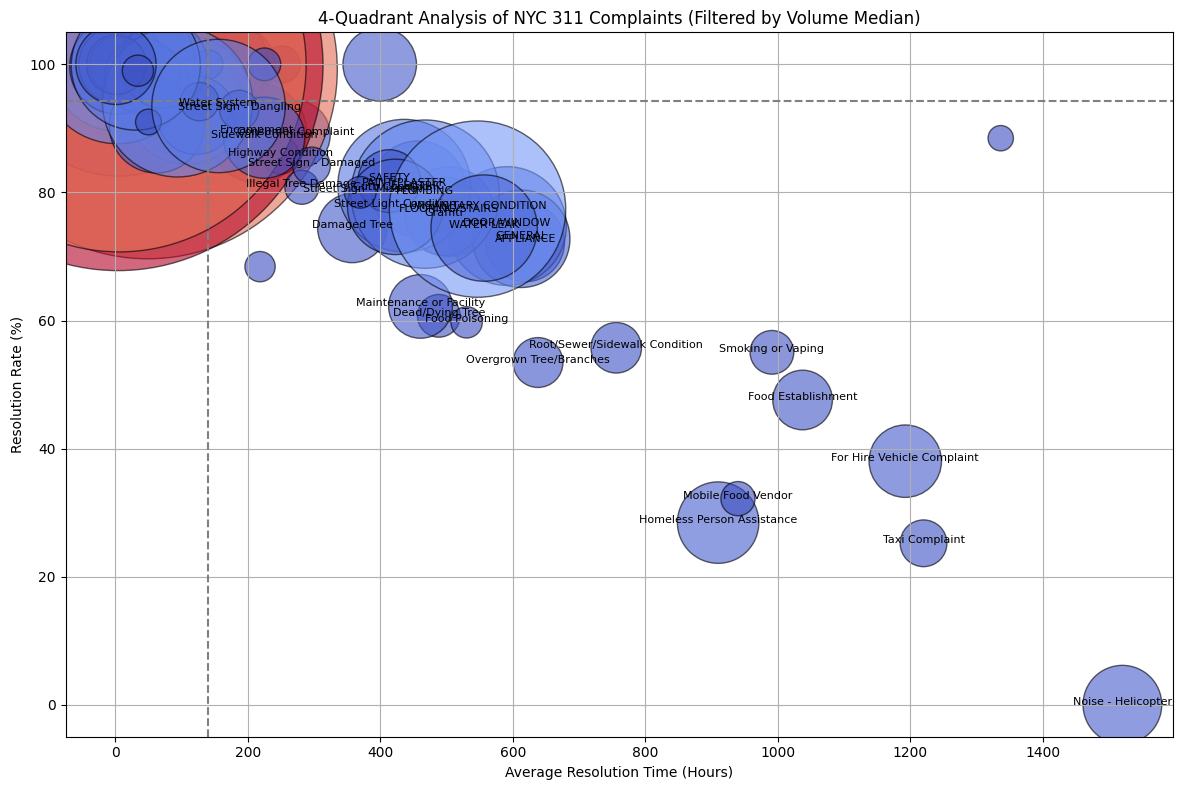

In [33]:
import matplotlib.pyplot as plt

# Recalculate medians (optional but safe)
x_median = summary_filtered["Avg_Resolution_Hours"].median()
y_median = summary_filtered["Resolved_Rate (%)"].median()

# Start figure
plt.figure(figsize=(12, 8))

# Scatter plot
plt.scatter(
    summary_filtered["Avg_Resolution_Hours"],
    summary_filtered["Resolved_Rate (%)"],
    s=summary_filtered["Total_Cases"] / 2,
    alpha=0.6,
    c=summary_filtered["Total_Cases"],
    cmap="coolwarm",
    edgecolors="black"
)

# Add quadrant lines
plt.axvline(x=x_median, color="gray", linestyle="--")
plt.axhline(y=y_median, color="gray", linestyle="--")

# Label points in bottom-right quadrant
for i, row in summary_filtered.iterrows():
    if row["Total_Cases"] > 1000 and row["Resolved_Rate (%)"] < y_median and row["Avg_Resolution_Hours"] > x_median:
        plt.text(
            row["Avg_Resolution_Hours"],
            row["Resolved_Rate (%)"],
            row["Complaint Type"],
            fontsize=8,
            ha='center'
        )

# Titles and labels
plt.xlabel("Average Resolution Time (Hours)")
plt.ylabel("Resolution Rate (%)")
plt.title("4-Quadrant Analysis of NYC 311 Complaints (Filtered by Volume Median)")
plt.grid(True)
plt.tight_layout()

# ✅ Save the chart BEFORE showing it
plt.savefig("nyc_311_quadrant_chart.png", dpi=300, bbox_inches='tight')

# Show the chart
plt.show()
